In [1]:
from IPython.display import display as print
import matplotlib.pyplot as plt
import pesummary
from pesummary.io import read
import h5py
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

/mnt/c/Users/cenlo/bbsonify/lib/python3.9/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


## Data Download

In [18]:
#Define Event Name
EventName = "GW150914"

print(f"Downloading Data...")

#Downlaod Data
from pesummary.gw.fetch import fetch_open_samples
file_name = fetch_open_samples(EventName, unpack=False, read_file=False, delete_on_exit=False, outdir="./", verbose=True)

'Downloading Data...'

In [3]:
# Reading with PESummary directly
data = read(file_name)

2025-11-22  22:49:16 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default


In [4]:
#Find Posteriors
samples_dict = data.samples_dict
posterior_samples = samples_dict["C01:Mixed"]

In [5]:
parameters = posterior_samples.parameters

## Plotting posterior distributions

'Plotting Posteriors...'

/mnt/c/Users/cenlo/bbsonify/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


' Saved chirp mass source figure: GW150914_chirp_mass_source.png'

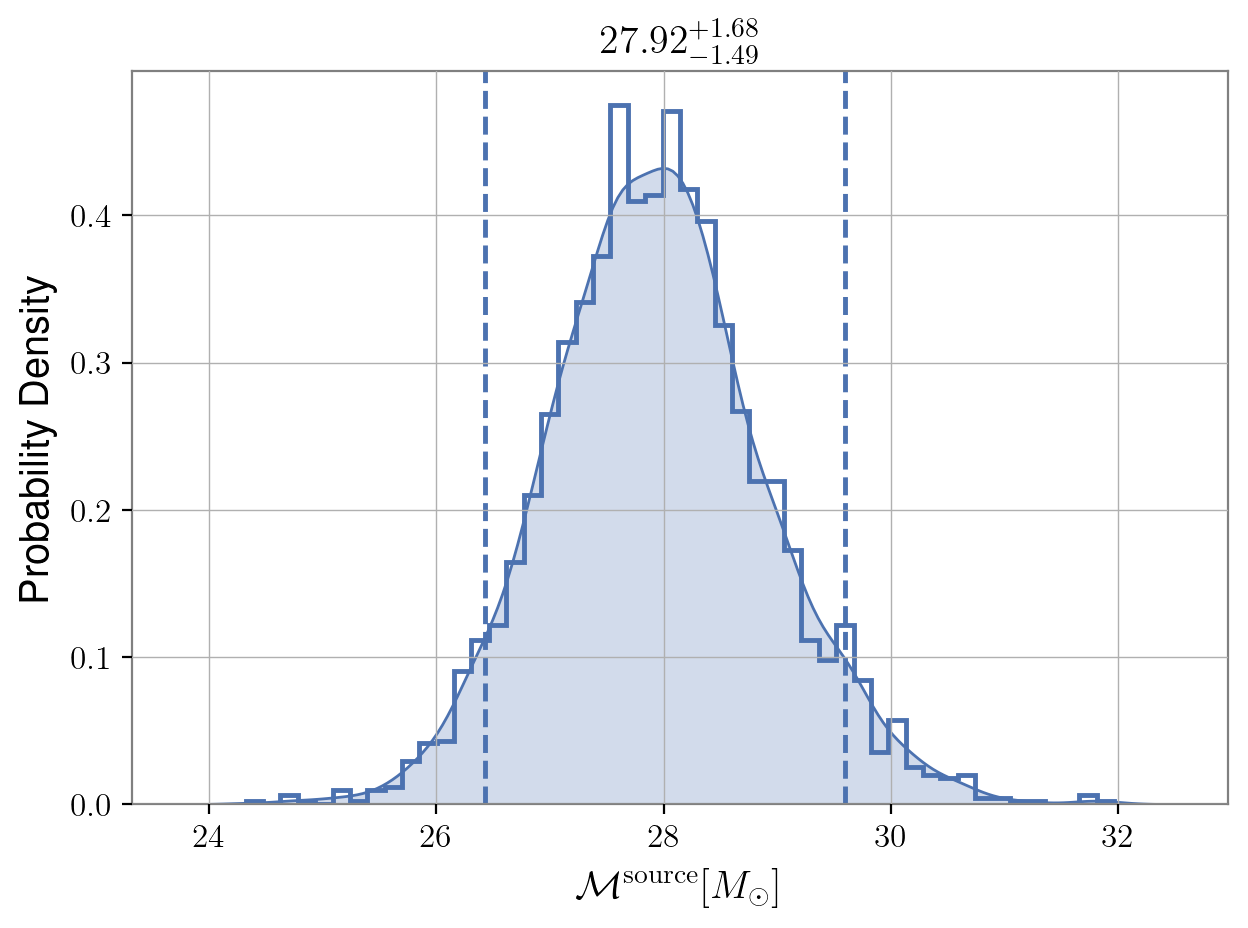

In [6]:
print(f"Plotting Posteriors...")

#Plot chirp mass source
fig = posterior_samples.plot("chirp_mass_source", type="hist", kde=True)
chirp_mass_filename = f"{EventName}_chirp_mass_source.png"
plt.savefig(chirp_mass_filename, dpi=300, bbox_inches='tight')
print(f" Saved chirp mass source figure: {chirp_mass_filename}")

' Saved posteriors corner plot figure: GW150914_posterior_corner_plot.png'

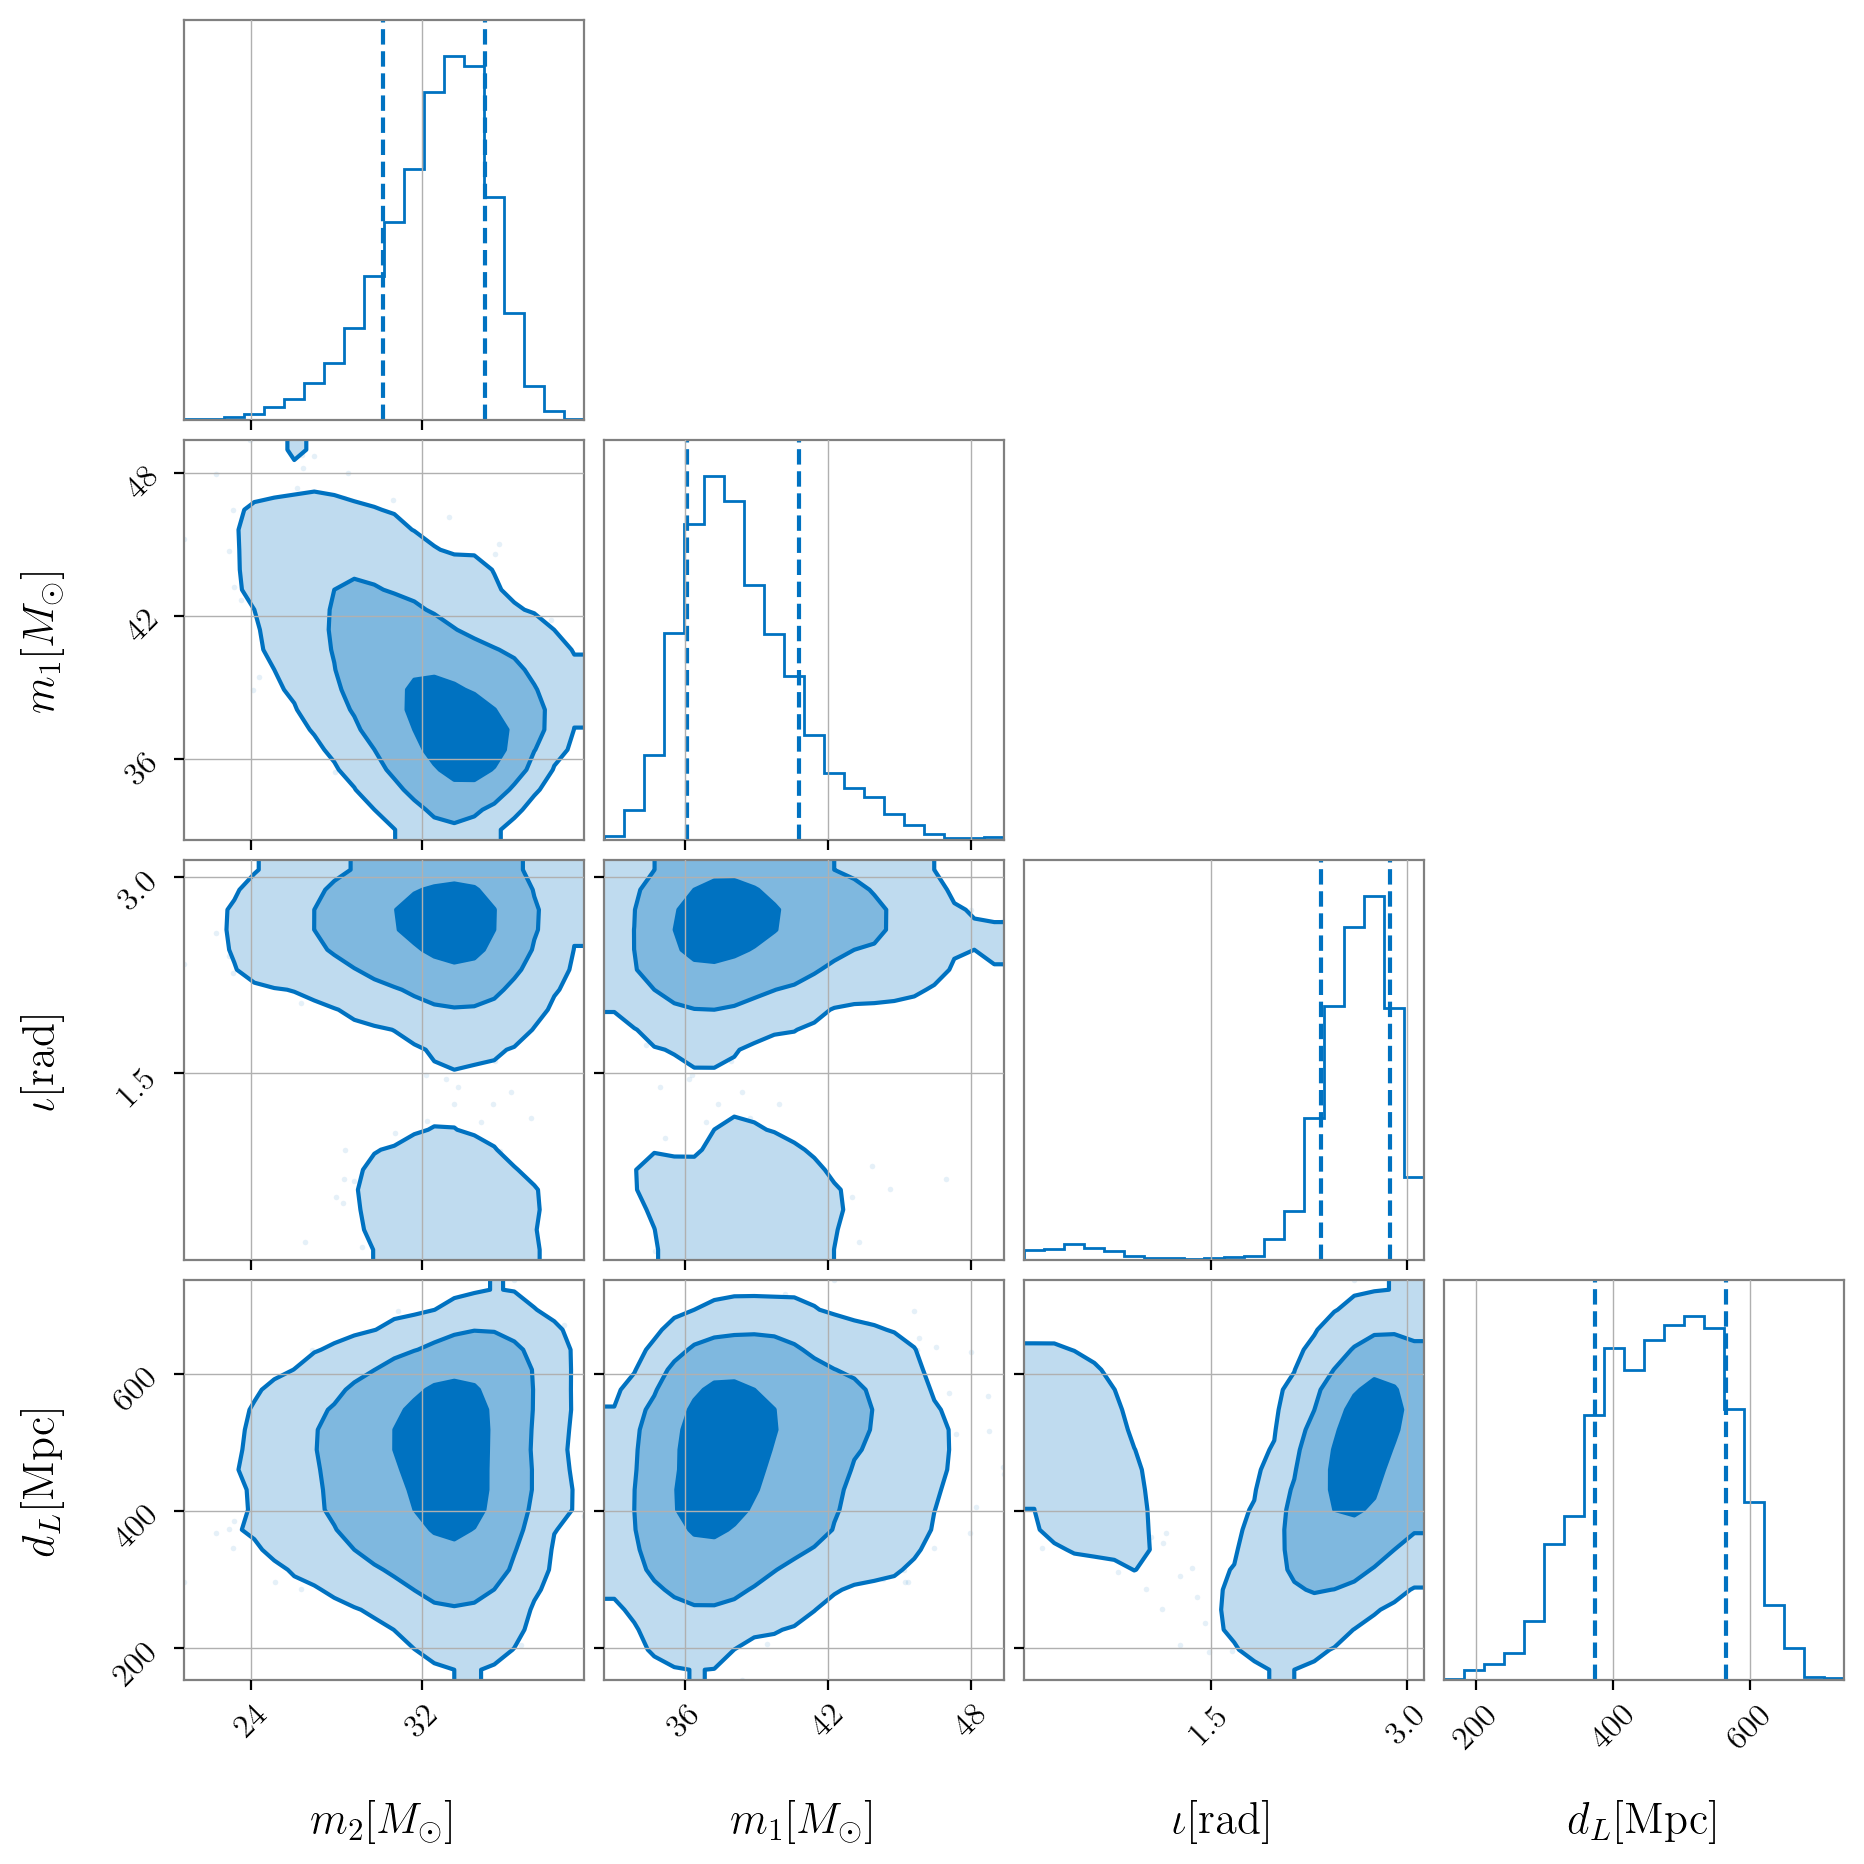

In [7]:
#Plot corner plot of most important params
fig = posterior_samples.plot(type="corner",
                             parameters=["mass_1",
                                         "mass_2",
                                         "iota",
                                         "luminosity_distance"])
post_corner_filename = f"{EventName}_posterior_corner_plot.png"
plt.savefig(post_corner_filename, dpi=300, bbox_inches='tight')
plt.close()
print(f" Saved posteriors corner plot figure: {post_corner_filename}")

' Saved spin posteriors plot figure: GW150914_spin_posterior_plot.png'

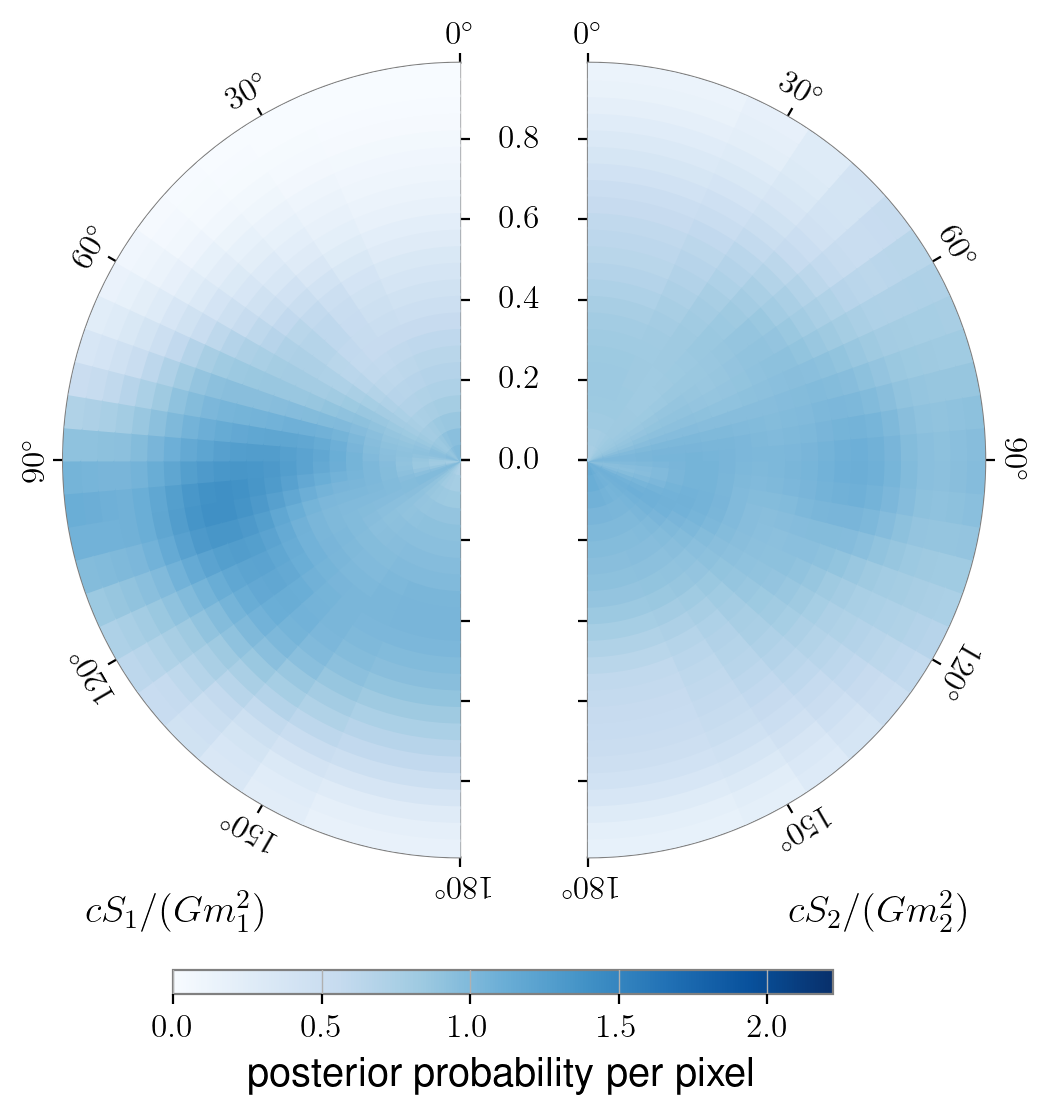

In [8]:
#Plot spin posterior figure
fig = posterior_samples.plot(type="spin_disk", colorbar=True, annotate=False,
                            show_label=True, cmap="Blues")
spin_post_filename = f"{EventName}_spin_posterior_plot.png"
plt.savefig(spin_post_filename, dpi=300, bbox_inches='tight')
print(f" Saved spin posteriors plot figure: {spin_post_filename}")

## Skymaps 

'Generating Skymap...'

/mnt/c/Users/cenlo/bbsonify/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


' Saved skymap figure: GW150914_skymap.png'

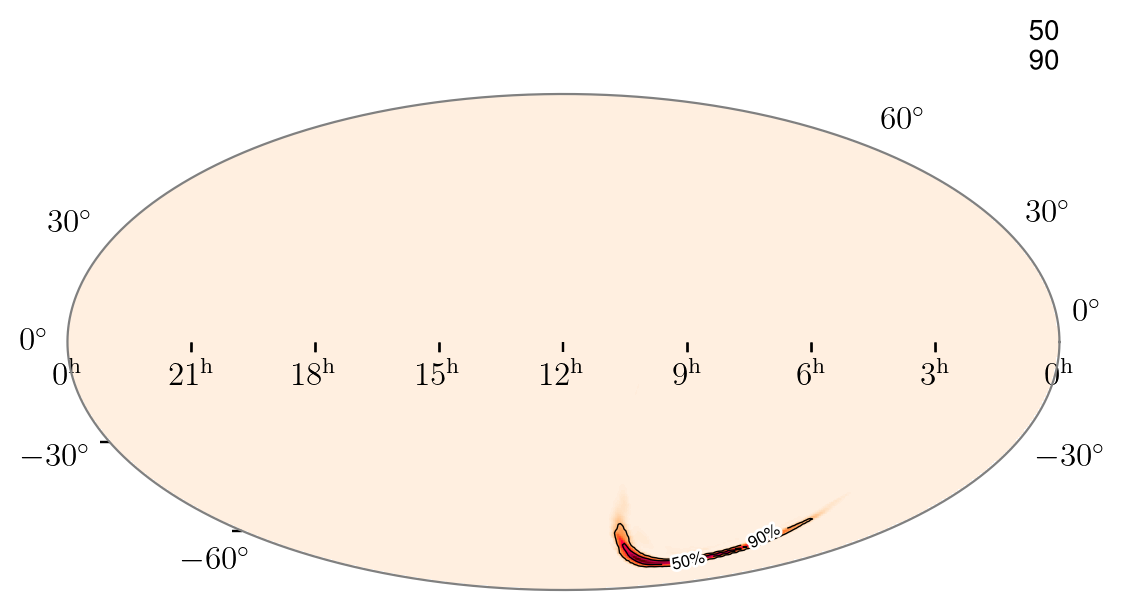

In [9]:
#Plot skymap figure
print(f"Generating Skymap...")
fig = data.skymap["C01:IMRPhenomXPHM"].plot(contour=[50, 90])
skymap_filename = f"{EventName}_skymap.png"
plt.savefig(skymap_filename, dpi=300, bbox_inches='tight')
print(f" Saved skymap figure: {skymap_filename}")

## Waveforms

In [10]:
print(f"Generating Waveform...")

'Generating Waveform...'

In [11]:
#Generate waveforms
approximant = "SEOBNRv4PHM"
index = 100
delta_t = 1. / 4096
f_low = 10.
waveforms = samples_dict[f"C01:{approximant}"].td_waveform(approximant, delta_t, f_low, f_ref=f_low, ind=index)

In [12]:
Nsamples = samples_dict["C01:SEOBNRv4PHM"].number_of_samples
samples_dict[f"C01:{approximant}"]["geocent_time"] = samples_dict[f"C01:IMRPhenomXPHM"].maxL["geocent_time"][0] * np.ones(Nsamples)

# Projected onto Detector

In [13]:
import gwpy

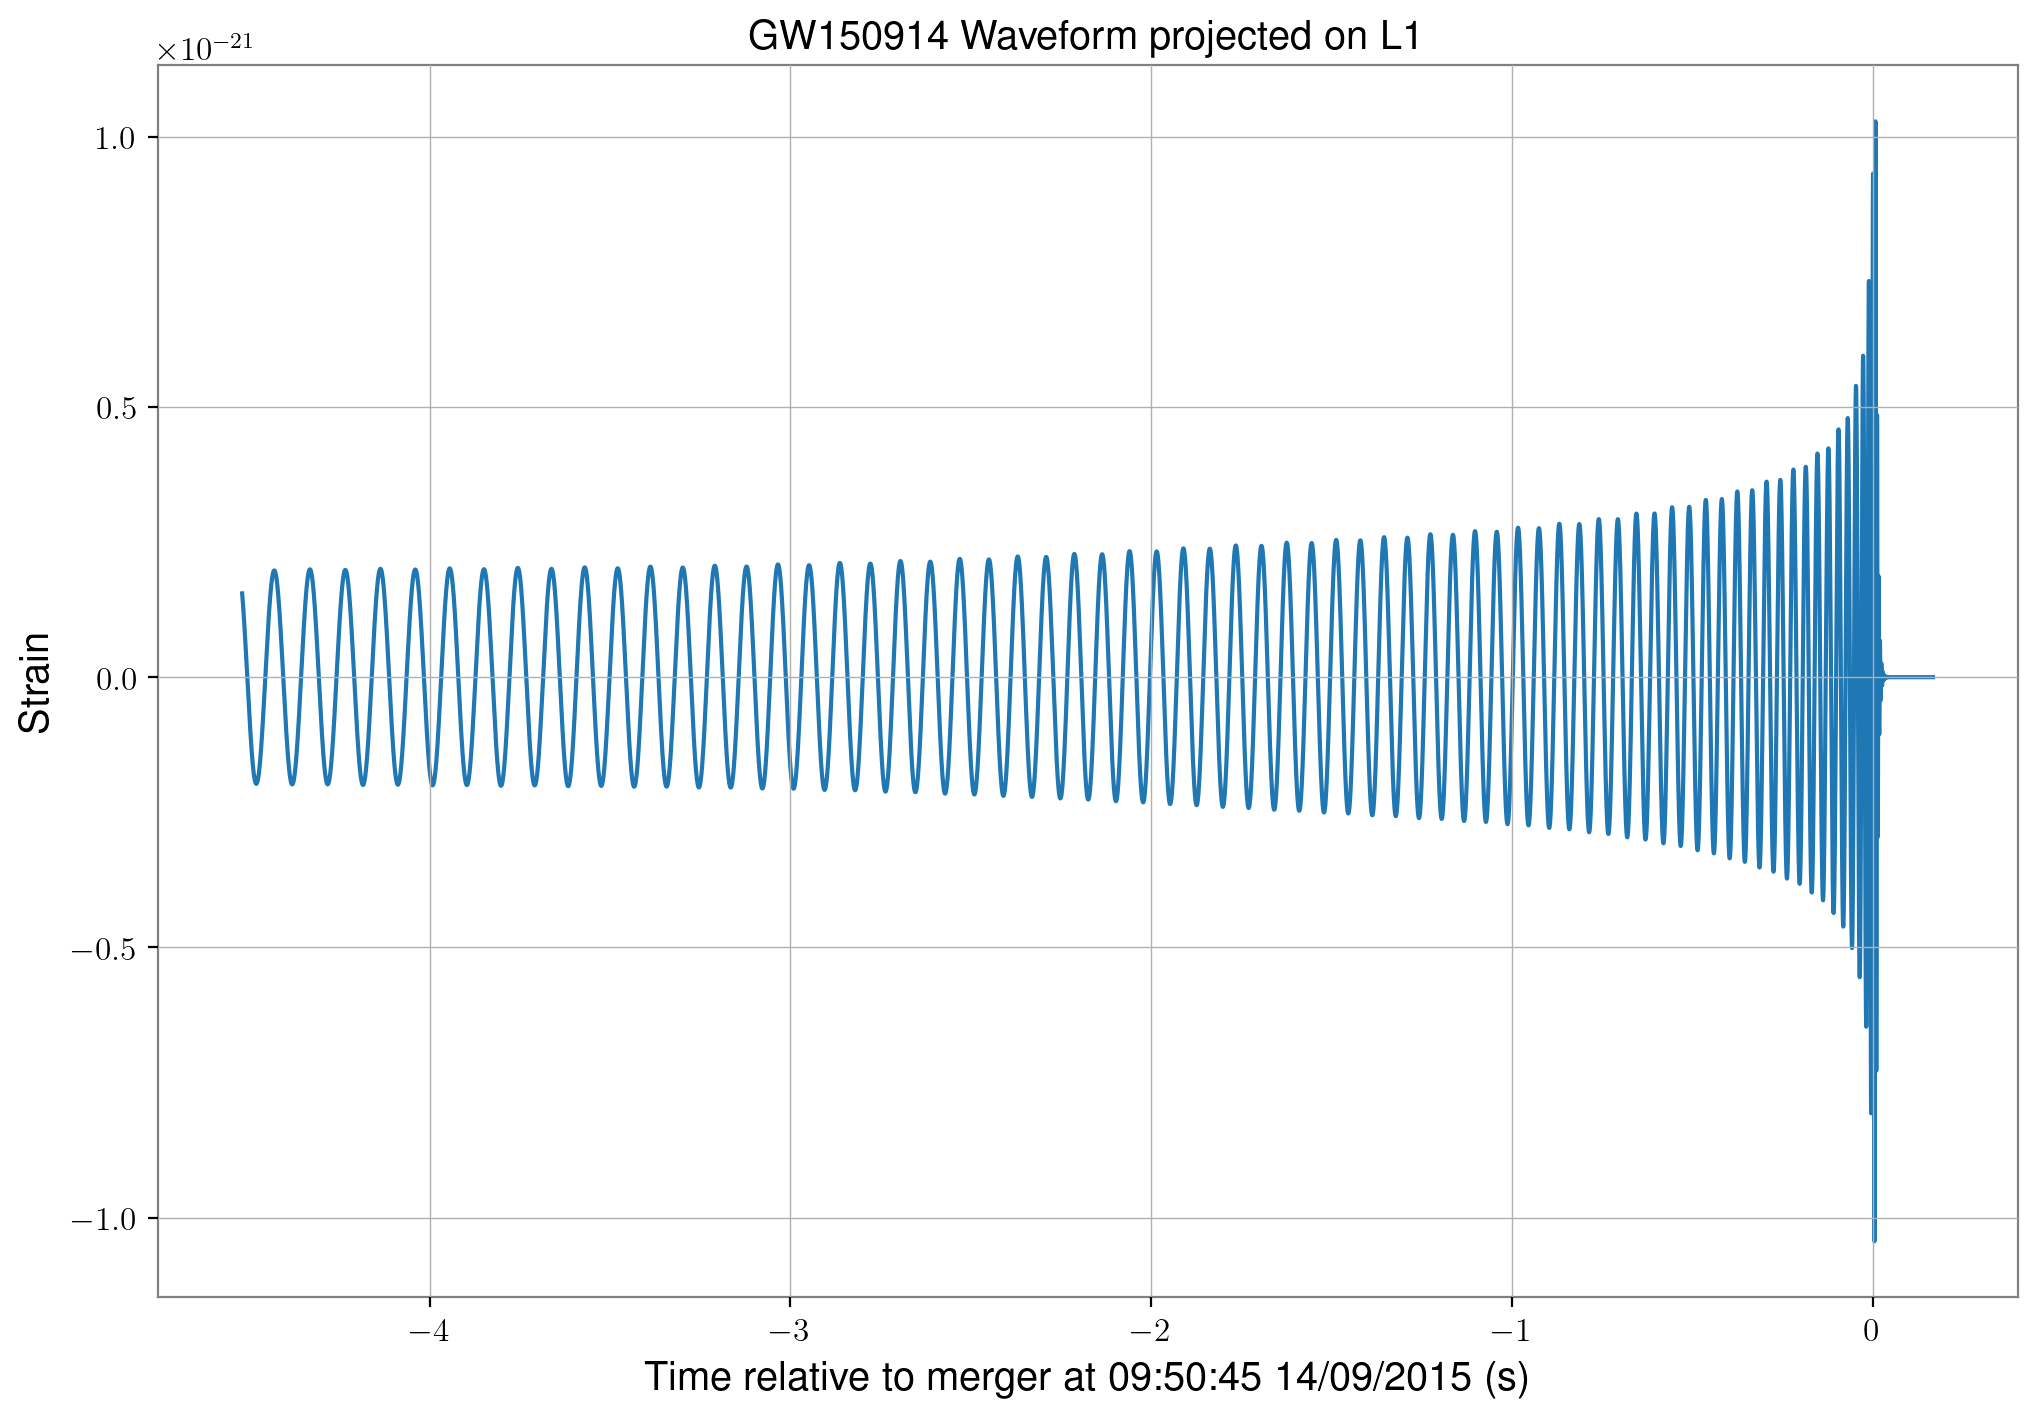

' Saved projected waveform figure: GW150914_projected_on_L1_waveform.png'

<Figure size 640x480 with 0 Axes>

In [14]:
#Project onto detector
DetectorID = 'L1' #Define which detector to project onto (L1 or H1)

merger_time = samples_dict[f"C01:IMRPhenomXPHM"].maxL["geocent_time"]
merger_time_UTC = gwpy.time.from_gps(merger_time).strftime("%H:%M:%S %d/%m/%Y")

maxL_projected_waveform = samples_dict[f"C01:{approximant}"].maxL_td_waveform(approximant, delta_t, f_low, f_ref=f_low, project=DetectorID)
fig = plt.figure(figsize=(12,8))
plt.plot(maxL_projected_waveform.times.value - float(merger_time), maxL_projected_waveform)
plt.xlabel("Time relative to merger at " + merger_time_UTC + ' (s)')
plt.ylabel("Strain")
titlestring = EventName + ' Waveform projected on ' + DetectorID
plt.title(titlestring)
plt.show()
plt.close()

#Plot projection
proj_wav_filename = f"{EventName}_projected_on_{DetectorID}_waveform.png"
plt.savefig(proj_wav_filename, dpi=300, bbox_inches='tight')
print(f" Saved projected waveform figure: {proj_wav_filename}")

## Full Sonification

In [15]:
import numpy as np
from scipy.io import wavfile
from scipy import signal

In [16]:
#Define sonification function
def sonify_gw_waveform(waveform, filename='gw_audio.wav', 
                       pitch_shift=1.0, time_stretch=1.0, gain=0.5):
    
    # Extract strain data and sample rate
    strain = np.array(waveform.value)
    original_sample_rate = int(1.0 / waveform.dt.value)
    
    print(f"Processing waveform...")
    print(f"  Original duration: {len(strain)/original_sample_rate:.4f} seconds")
    print(f"  Original sample rate: {original_sample_rate} Hz")
    
    # Apply time stretch first (affects duration, not pitch)
    if time_stretch != 1.0:
        num_samples_stretched = int(len(strain) * time_stretch)
        strain = signal.resample(strain, num_samples_stretched)
        print(f"  Time stretched by {time_stretch}x")
    
    # Apply pitch shift (affects frequency, not duration at this stage)
    final_sample_rate = original_sample_rate
    if pitch_shift != 1.0:
        num_samples_pitched = int(len(strain) * pitch_shift)
        strain = signal.resample(strain, num_samples_pitched)
        final_sample_rate = int(original_sample_rate * pitch_shift)
        print(f"  Pitch shifted by {pitch_shift}x")
    
    # Normalize to [-1, 1] range
    max_amplitude = np.max(np.abs(strain))
    if max_amplitude > 0:
        strain_normalized = strain / max_amplitude
    else:
        print("Warning: Waveform has zero amplitude!")
        strain_normalized = strain
    
    # Apply gain (volume control)
    strain_normalized = strain_normalized * np.clip(gain, 0.0, 1.0)
    
    # Convert to 16-bit PCM (standard audio format)
    audio_data = np.int16(strain_normalized * 32767)
    
    # Save as WAV file
    wavfile.write(filename, final_sample_rate, audio_data)
    
    # Print summary
    duration = len(audio_data) / final_sample_rate
    print(f"  Audio saved successfully!")
    print(f"  Filename: {filename}")
    print(f"  Duration: {duration:.4f} seconds")
    print(f"  Sample rate: {final_sample_rate} Hz")
    print(f"  Data points: {len(audio_data)}")
    
    return filename

In [17]:
#Custom sonification parameters
wav_output_filename = 'gw_original.wav' #Custome name out
pitch_shift_ = 1.0 #Shift pitch (positive multiplier)
time_stretch_ = 1.0 #Stretch total duration (positive multiplier)
gain_ = 0.5 #Adjust gain (default 0.5, positive multiplier)

#Execute sonification
sonify_gw_waveform(maxL_projected_waveform, 
                   filename='gw_original.wav',
                   pitch_shift=pitch_shift_, 
                   time_stretch=time_stretch_, 
                   gain=gain_)

'Processing waveform...'

'  Original duration: 4.6880 seconds'

'  Original sample rate: 4096 Hz'

'  Audio saved successfully!'

'  Filename: gw_original.wav'

'  Duration: 4.6880 seconds'

'  Sample rate: 4096 Hz'

'  Data points: 19202'

'gw_original.wav'